In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsRegressor

from src.models.scoring import distance75

# Setting styles
InteractiveShell.ast_node_interactivity = "all"
sns.set(style="whitegrid", color_codes=True, rc={"figure.figsize": (12.7, 9.27)})

random_state = 123


In [2]:

df = pd.read_csv(os.path.join("data", "processed", "train.csv"))
df = df.drop(columns=["train", "relativeposition", "spaceid"])

df_valid = pd.read_csv(os.path.join("data", "processed", "test.csv"))
df_valid = df_valid.drop(columns=["train", "relativeposition", "spaceid"])


In [3]:

X = df.drop(columns=["longitude", "latitude", "floor", "buildingid"])
y = pd.DataFrame(
    {
        "lon": df.longitude,
        "lat": df.latitude,
        "floor": df.floor,
        "building": df.buildingid,
    }
)

X_valid = df_valid.drop(columns=["longitude", "latitude", "floor", "buildingid"])
y_valid = pd.DataFrame(
    {
        "lon": df_valid.longitude,
        "lat": df_valid.latitude,
        "floor": df_valid.floor,
        "building": df_valid.buildingid,
    }
)


In [4]:


def calculate_distance(y, y_pred):
    distance = distance75(y, y_pred)
    return np.mean(distance)


distance_scorer = make_scorer(calculate_distance, greater_is_better=False)



In [5]:


def squared_distance(weights):
    # replacing zero values with machine epsilon
    weights[weights == 0] = np.finfo(float).eps
    weights = [
        (1 / weights_obs ** 2) / np.sum(1 / weights_obs ** 2) for weights_obs in weights
    ]
    return weights


param_grid = {
    "n_neighbors": [1, 2, 3, 4, 5],
    "weights": ["uniform", "distance", squared_distance],
    "metric": ["euclidean", "manhattan"],
}

knn_model = KNeighborsRegressor()

# there might be some inherent order in the dataset
# so shuffling to get rid of this
folds = KFold(n_splits=10, shuffle=True, random_state=random_state)

param_search = GridSearchCV(
    knn_model, param_grid, scoring=distance_scorer, n_jobs=-2, cv=folds, verbose=2
)

param_search.fit(X, y)
print("Best Params:")
print(param_search.best_params_)
print("Best CV Score:")
print(-param_search.best_score_)

best_params = param_search.best_params_


Fitting 10 folds for each of 30 candidates, totalling 300 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed: 26.4min finished
Best Params:
{'metric': 'manhattan', 'n_neighbors': 2, 'weights': <function squared_distance at 0x7f9f69517598>}
Best CV Score:
2.66036866826425


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=-2,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5],
                         'weights': ['uniform', 'distance',
                                     <function squared_distance at 0x7f9f69517598>]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(calculate_distance, greater_is_better=False),
             verbose=2)

In [6]:

knn_model = KNeighborsRegressor(**best_params)
knn_model.fit(X, y)

pred = knn_model.predict(X_valid)

pred_lon = pred[:, 0]
pred_lat = pred[:, 1]
pred_floor = np.round(pred[:, 2], decimals=0)
pred_building = np.round(pred[:, 3], decimals=0)

distance = distance75(y_valid, pred)
score = np.mean(distance)
lon_score = np.mean(np.absolute(pred_lon - y_valid.lon))
lat_score = np.mean(np.absolute(pred_lat - y_valid.lat))
right_floor = np.round(np.mean(pred_floor == y_valid.floor) * 100, 2)
right_building = np.round(np.mean(pred_building == y_valid.building) * 100, 2)

predictions = pd.DataFrame(
    {
        "LATITUDE": pred_lat,
        "LONGITUDE": pred_lon,
        "FLOOR": pred_floor,
        "distance": distance,
    }
)

true_values = pd.DataFrame(
    {
        "LATITUDE": y_valid.lat,
        "LONGITUDE": y_valid.lon,
        "FLOOR": y_valid.floor,
        "distance": distance,
    }
)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights=<function squared_distance at 0x7f9f69517598>)

Mean error in distance75: 16.606624697693242
Latitude error: 7.353748357391218
Longitude error: 7.828933946062602
Floors correct: 87.49 %
Building correct: 98.56 %


Text(0.5, 1.0, 'Predictions Floor 0')

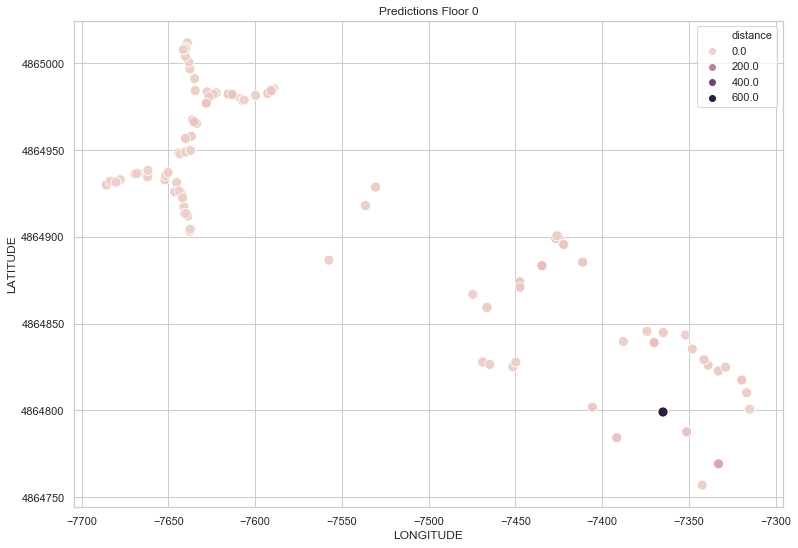

Text(0.5, 1.0, 'Real Values Floor 0')

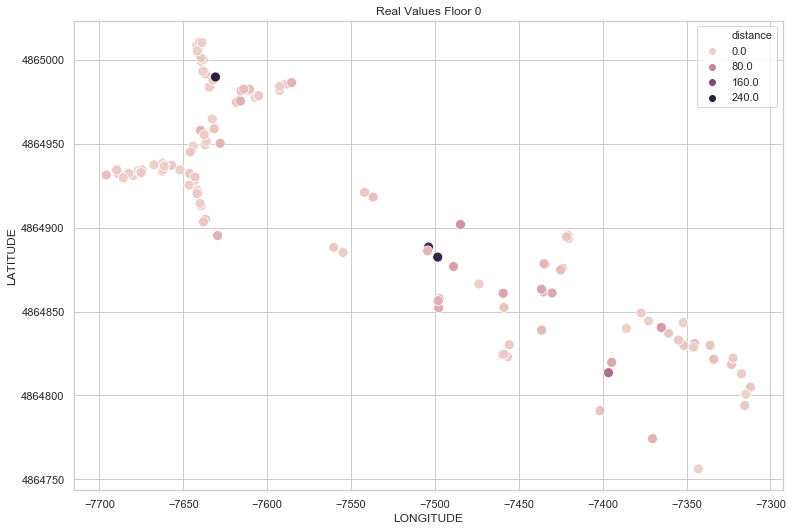

Text(0.5, 1.0, 'Predictions Floor 1')

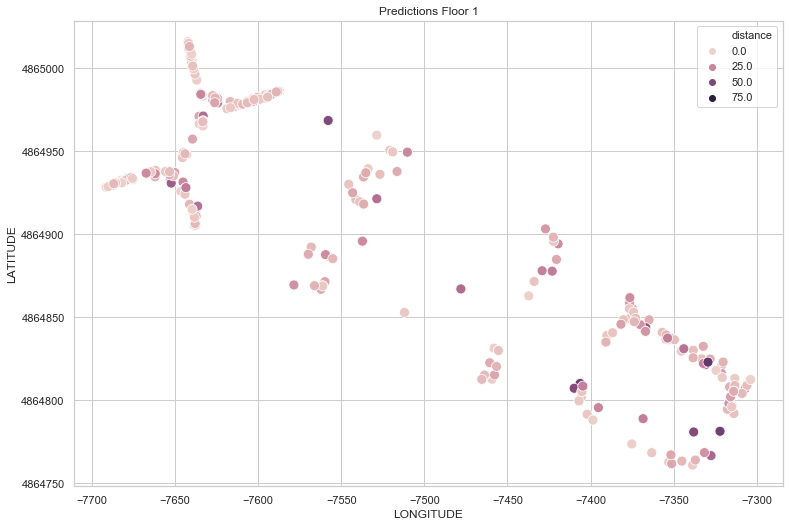

Text(0.5, 1.0, 'Real Values Floor 1')

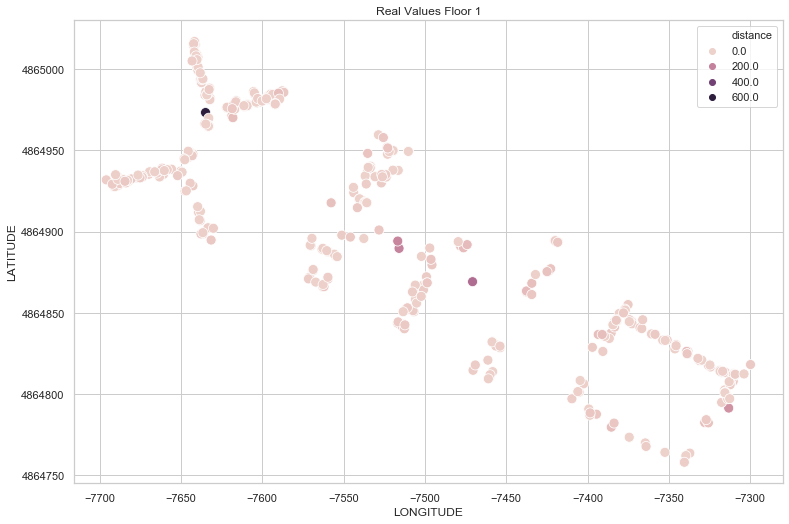

Text(0.5, 1.0, 'Predictions Floor 2')

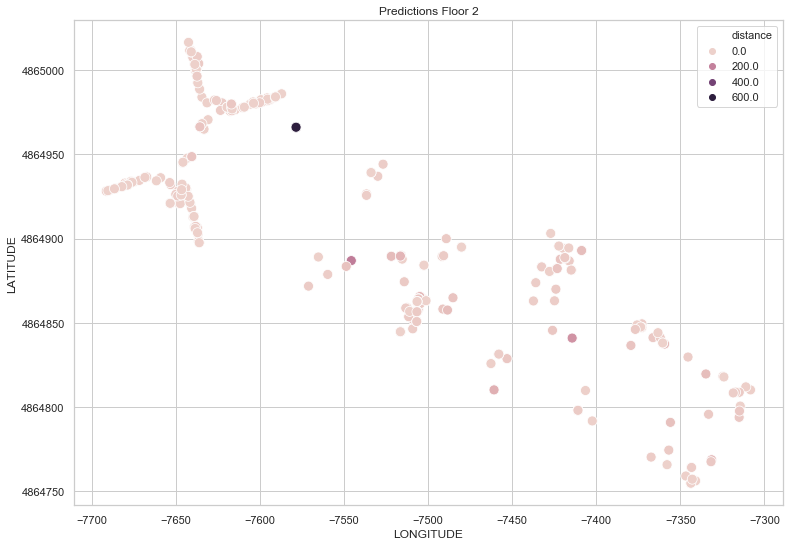

Text(0.5, 1.0, 'Real Values Floor 2')

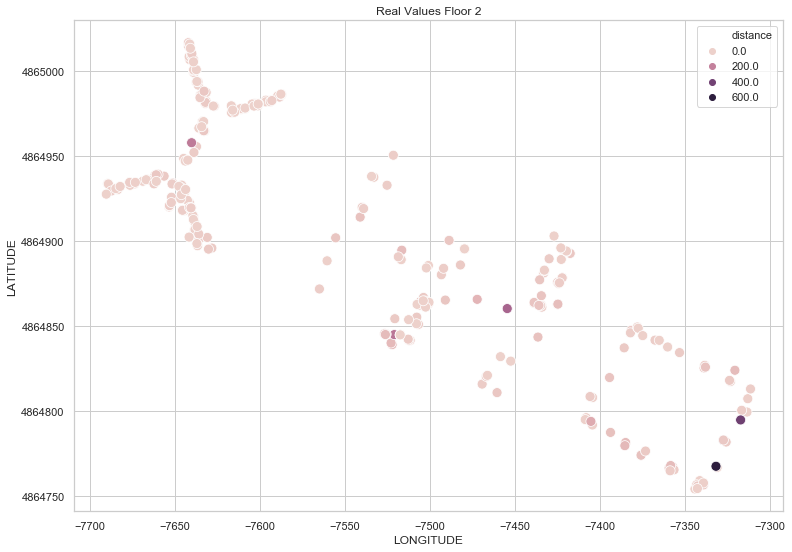

Text(0.5, 1.0, 'Predictions Floor 3')

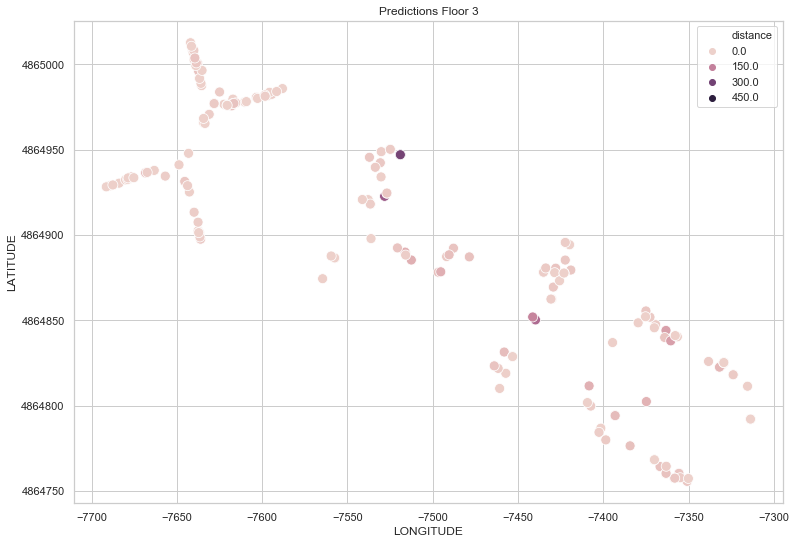

Text(0.5, 1.0, 'Real Values Floor 3')

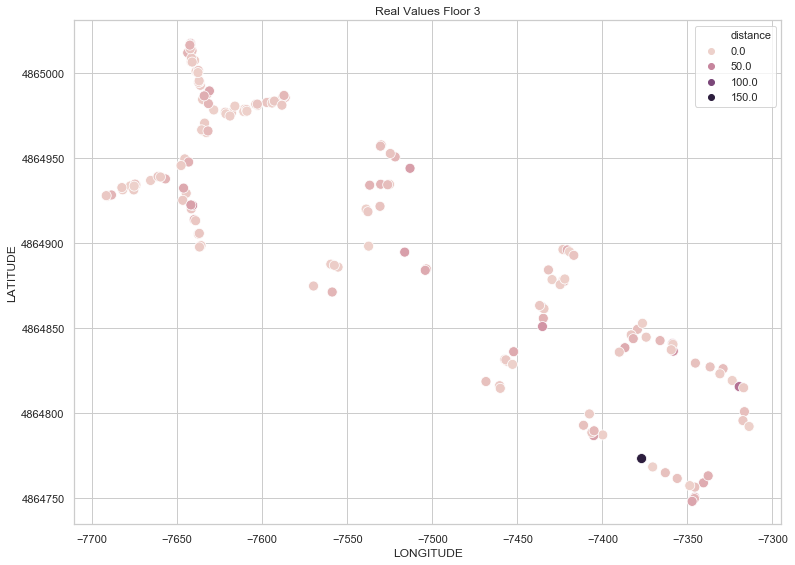

Text(0.5, 1.0, 'Predictions Floor 4')

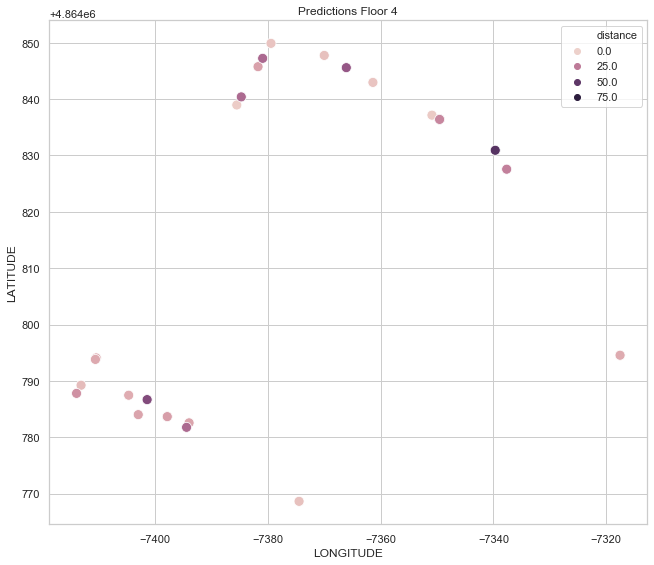

Text(0.5, 1.0, 'Real Values Floor 4')

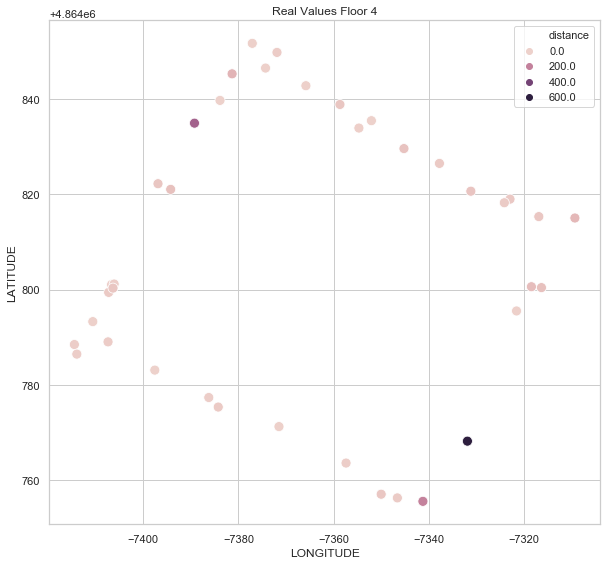

In [7]:

print(f"Mean error in distance75: {score}")
print(f"Latitude error: {lat_score}")
print(f"Longitude error: {lon_score}")
print(f"Floors correct: {right_floor} %")
print(f"Building correct: {right_building} %")

for floor in sorted(predictions.FLOOR.unique()):
    fig, ax = plt.subplots()
    sns.scatterplot(
        x="LONGITUDE",
        y="LATITUDE",
        hue="distance",
        ax=ax,
        s=100,
        data=predictions[predictions["FLOOR"] == int(floor)],
    )
    ax.set_aspect(aspect="equal")
    plt.title(f"Predictions Floor {int(floor)}")
    plt.show()

    fig, ax = plt.subplots()
    sns.scatterplot(
        x="LONGITUDE",
        y="LATITUDE",
        hue="distance",
        s=100,
        data=true_values[true_values["FLOOR"] == int(floor)],
        ax=ax,
    )
    ax.set_aspect(aspect="equal")
    plt.title(f"Real Values Floor {int(floor)}")
    plt.show()



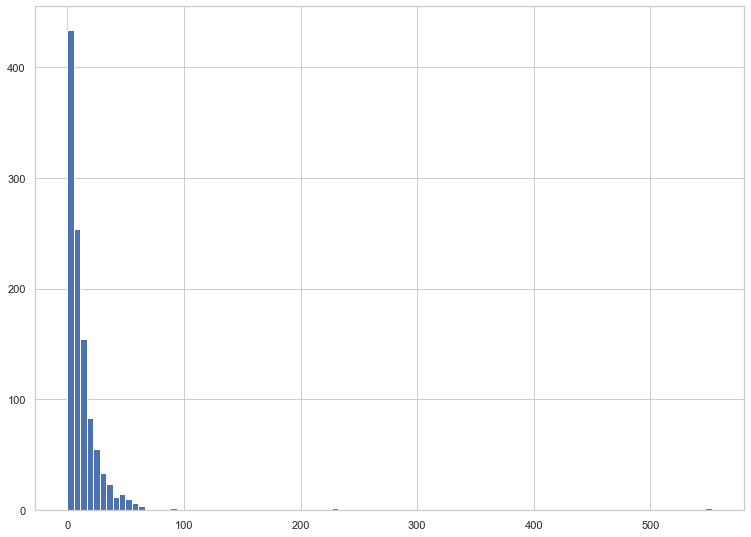

In [8]:

predictions.distance.hist(bins=100)
